# CS-E4600 — Programming project

## Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.cluster.vq import vq, kmeans, whiten

## Read file

In [133]:
#file = 'test.txt'
file = 'ca-GrQc.txt'
#file = 'Oregon-1.txt'
#file = 'ca-HepPh.txt'

## Read First line info and Edges

In [134]:
with open('./graphs_processed/' + file) as f:
    first_line = f.readline()
first_line = first_line.split()

num_nodes = int(first_line[2])
num_edges = int(first_line[3])
k = int(first_line[4])
print(num_nodes, num_edges, k)

    
pd_edges = pd.read_csv('./graphs_processed/' + file, sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

4158 13428 2


## Select Distinct Nodes

In [135]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [136]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes and Edges to Numpy

In [137]:
nodes = pd_nodes.values
edges = pd_edges.values
nodes2 = np.arange(num_nodes)
#print(nodes.shape, nodes.shape)
print(nodes)
print(nodes2)
nodes = nodes2
#nodes.shape, edges.shape

[   0    1    2 ... 3971 4095 4138]
[   0    1    2 ... 4155 4156 4157]


## Create Adjacency Matrix

what to do with too big arrays??

In [138]:
adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

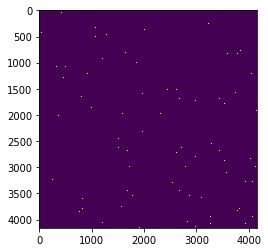

In [139]:
for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
plt.imshow(adjacency_matrix)

## Create Laplacian Matrix

In [140]:
laplacian = csgraph.laplacian(adjacency_matrix, normed=True)
np.sum(laplacian)

656.1491255509026

## Alternative way for the Laplacian Matrix

In [44]:
degrees = np.sum(adjacency_matrix, axis=0)
L_normed = np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L_normed[i,j] = -1.0/(np.sqrt(degrees[i]*degrees[j]))

In [45]:
degrees = np.sum(adjacency_matrix, axis=0)
L = degrees * np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L[i,j] = -1

In [46]:
np.sum(L_normed)

0.2532426070721102

## Eigen-decomposition

In [107]:
_w, _v = np.linalg.eig(L_normed)

[-1.11022302e-16  1.58813117e-01  1.58550636e+00  1.10746857e+00
  1.31487862e+00  1.60762522e+00  1.50000000e+00  7.25708115e-01]


In [147]:
w, v = eigsh(laplacian, k, which="SA")
print(v)

[[0.00610346 0.0009242 ]
 [0.01220693 0.00347964]
 [0.01220693 0.00196978]
 ...
 [0.00610346 0.00146128]
 [0.0172632  0.00271272]
 [0.0086316  0.00168531]]


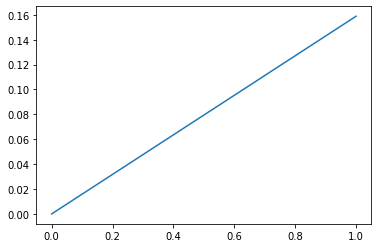

In [63]:
plt.plot(w)
plt.show()

## Selects second smallest eigenvalue and corresponding eigenvector

In [71]:
eig_val_idx = np.argpartition(w,k-1)[1]
eig_val_idx
eig_vec = v[:,eig_val_idx]

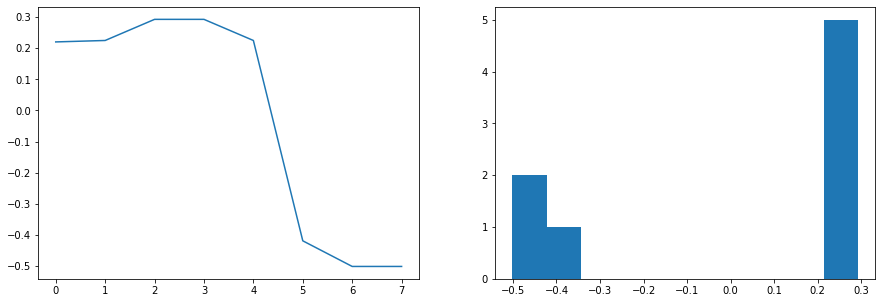

In [53]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(eig_vec)
plt.subplot(1, 2, 2)
plt.hist(eig_vec)
plt.show()

## K-means clustering

Should be improved to enforce balanced cluster sizes

In [148]:
whitened = whiten(v)
k_means, distortion = kmeans(v,k)
print(k_means)

[[9.86045067e-03 1.42100274e-03]
 [2.34473598e-02 9.21011123e-05]]


## Select cluster for all vertices

In [149]:
def cluster(node, k_means):
    node_cluster = 0
    node_distance = np.linalg.norm(node - k_means[0,:])
    
    for i in range(1,k_means.shape[0]):
        tmp_distance = np.linalg.norm(node - k_means[i,:])
        if (tmp_distance < node_distance):
            node_distance = tmp_distance
            node_cluster = i
                
    return node_cluster
        

In [150]:
clusters = np.zeros((num_nodes,1))
for j in range(clusters.size):
    clusters[j] = cluster(v[j,:], k_means)

In [151]:
unique, counts = np.unique(clusters, return_counts=True)

In [152]:
print(clusters)
print(counts)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]
[3183  975]


## Calculate cost for clusters